# TP2 Módulo 2: Apache Spark
## Ejercicio 2
## Jorge Pablo Ávila Gómez

Para realizar este ejercicio he elegido un dataset de kaggle:
#### dataset : https://www.kaggle.com/sakshigoyal7/credit-card-customers
El dataset contiene información de clientes de un banco. Se pretende estudiar la tendencia de estos clientes a dejar de usar el servicio de tarjetas de crédito.

Es importante poder predecir si el cliente piensa en dejar el servicio de tarjeta de crédito para que puedan tomar una posición proactiva e intentar mantener al cliente.

El dataset consiste en 10.000 clientes mencionando su edad, salario, estado social, categoria de la tarjeta de crédito... Un total de 18 características.

De todo el dataset un 16.07% ha dejado el servicio, es decir la clase que queremos predecir está en minoría.

#### Objetivo:
Lo importante es conseguir identificar a los clientes que van a abandonar. Predecir clientes que no van a abandonar como que sí no daña al negocio. Pero predecir clientes que van a abandonar como que no si daña el negocio.

En consecuencia, la medida más importante que hay que mejorar es el recall.
En la descripción del kaggle se indica que se intente superar el 62%.

In [1]:
# Cargar el dataset en un Dataframe
df = spark.read.csv(
    "../RecursosdelTema2.2/BankChurners.csv",
    mode="DROPMALFORMED",
    inferSchema=True,
    header=True,
)

In [2]:
df.printSchema()

root
 |-- CLIENTNUM: integer (nullable = true)
 |-- Attrition_Flag: string (nullable = true)
 |-- Customer_Age: integer (nullable = true)
 |-- Gender: string (nullable = true)
 |-- Dependent_count: integer (nullable = true)
 |-- Education_Level: string (nullable = true)
 |-- Marital_Status: string (nullable = true)
 |-- Income_Category: string (nullable = true)
 |-- Card_Category: string (nullable = true)
 |-- Months_on_book: integer (nullable = true)
 |-- Total_Relationship_Count: integer (nullable = true)
 |-- Months_Inactive_12_mon: integer (nullable = true)
 |-- Contacts_Count_12_mon: integer (nullable = true)
 |-- Credit_Limit: double (nullable = true)
 |-- Total_Revolving_Bal: integer (nullable = true)
 |-- Avg_Open_To_Buy: double (nullable = true)
 |-- Total_Amt_Chng_Q4_Q1: double (nullable = true)
 |-- Total_Trans_Amt: integer (nullable = true)
 |-- Total_Trans_Ct: integer (nullable = true)
 |-- Total_Ct_Chng_Q4_Q1: double (nullable = true)
 |-- Avg_Utilization_Ratio: double (n

In [3]:
# Número de clientes
df.count()

10127

In [4]:
# Número de columnas
len(df.columns)

23

In [5]:
# No falta ningún valor
from pyspark.sql.functions import isnan, when, count, col

df.select([count(when(isnan(c), c)).alias(c) for c in df.columns]).show()

+---------+--------------+------------+------+---------------+---------------+--------------+---------------+-------------+--------------+------------------------+----------------------+---------------------+------------+-------------------+---------------+--------------------+---------------+--------------+-------------------+---------------------+----------------------------------------------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------------------------------------+
|CLIENTNUM|Attrition_Flag|Customer_Age|Gender|Dependent_count|Education_Level|Marital_Status|Income_Category|Card_Category|Months_on_book|Total_Relationship_Count|Months_Inactive_12_mon|Contacts_Count_12_mon|Credit_Limit|Total_Revolving_Bal|Avg_Open_To_Buy|Total_Amt_Chng_Q4_Q1|Total_Trans_Amt|Total_Trans_Ct|Total_Ct_Chng_Q4_Q1|Avg_Utilization_Ratio|Naive_Bayes_Classifier_Attrition_Fl

In [6]:
df.columns

['CLIENTNUM',
 'Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1',
 'Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2']

In [7]:
# Eliminamos la columna de índices y las dos últimas que vienen por error en el dataset
columns_to_drop = [
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_1",
    "Naive_Bayes_Classifier_Attrition_Flag_Card_Category_Contacts_Count_12_mon_Dependent_count_Education_Level_Months_Inactive_12_mon_2",
    "CLIENTNUM",
]
for col in columns_to_drop:
    df = df.drop(col)
df.columns

['Attrition_Flag',
 'Customer_Age',
 'Gender',
 'Dependent_count',
 'Education_Level',
 'Marital_Status',
 'Income_Category',
 'Card_Category',
 'Months_on_book',
 'Total_Relationship_Count',
 'Months_Inactive_12_mon',
 'Contacts_Count_12_mon',
 'Credit_Limit',
 'Total_Revolving_Bal',
 'Avg_Open_To_Buy',
 'Total_Amt_Chng_Q4_Q1',
 'Total_Trans_Amt',
 'Total_Trans_Ct',
 'Total_Ct_Chng_Q4_Q1',
 'Avg_Utilization_Ratio']

# EDA

In [8]:
df.toPandas().info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 20 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Attrition_Flag            10127 non-null  object 
 1   Customer_Age              10127 non-null  int32  
 2   Gender                    10127 non-null  object 
 3   Dependent_count           10127 non-null  int32  
 4   Education_Level           10127 non-null  object 
 5   Marital_Status            10127 non-null  object 
 6   Income_Category           10127 non-null  object 
 7   Card_Category             10127 non-null  object 
 8   Months_on_book            10127 non-null  int32  
 9   Total_Relationship_Count  10127 non-null  int32  
 10  Months_Inactive_12_mon    10127 non-null  int32  
 11  Contacts_Count_12_mon     10127 non-null  int32  
 12  Credit_Limit              10127 non-null  float64
 13  Total_Revolving_Bal       10127 non-null  int32  
 14  Avg_Op

In [9]:
df.toPandas().head(5)

,Attrition_Flag,Customer_Age,Gender,Dependent_count,Education_Level,Marital_Status,Income_Category,Card_Category,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
0,Existing Customer,45,M,3,High School,Married,$60K - $80K,Blue,39,5,1,3,12691.0,777,11914.0,1.335,1144,42,1.625,0.061
1,Existing Customer,49,F,5,Graduate,Single,Less than $40K,Blue,44,6,1,2,8256.0,864,7392.0,1.541,1291,33,3.714,0.105
2,Existing Customer,51,M,3,Graduate,Married,$80K - $120K,Blue,36,4,1,0,3418.0,0,3418.0,2.594,1887,20,2.333,0.000
3,Existing Customer,40,F,4,High School,Unknown,Less than $40K,Blue,34,3,4,1,3313.0,2517,796.0,1.405,1171,20,2.333,0.760
4,Existing Customer,40,M,3,Uneducated,Married,$60K - $80K,Blue,21,5,1,0,4716.0,0,4716.0,2.175,816,28,2.500,0.000


In [10]:
# Descripción de las variables numéricas
numeric_features = [t[0] for t in df.dtypes if t[1] == "int" or t[1] == "double"]
df.select(numeric_features).toPandas().describe()

,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [11]:
# Descripción de las variables categóricas
cat_features = [t[0] for t in df.dtypes if t[1] == "string"]
df.select(cat_features).toPandas().describe()

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


Vemos que las variables categóricas tienen pocas categorias, la que más es 'education_level' que tiene 7. Se codificarán con one hot encoding y no se les realizará ningún procesamiento extra.

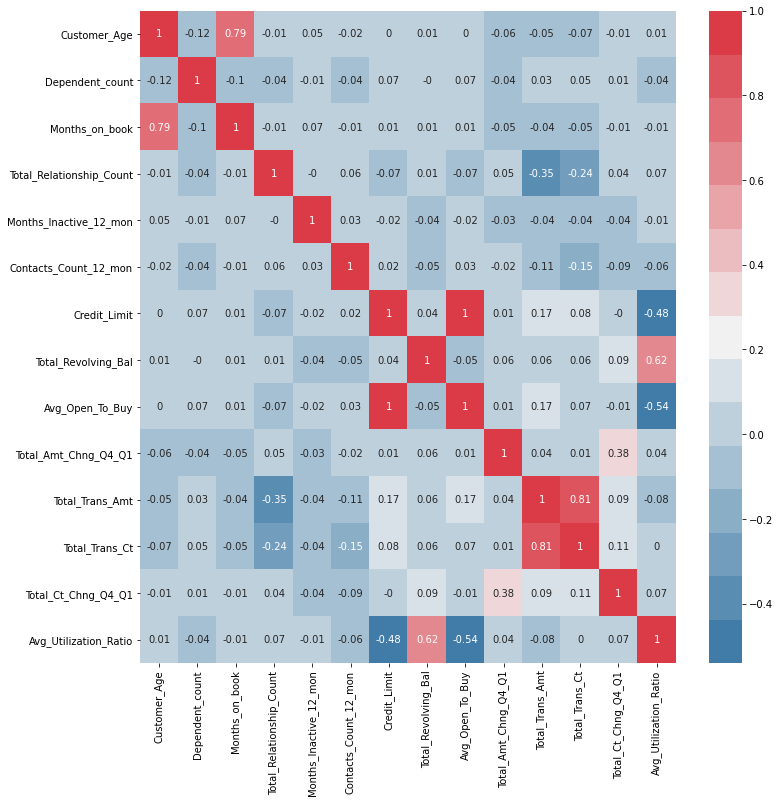

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

correlation = np.round(df.toPandas().corr(), 2)
plt.figure(figsize=(10, 10))
sns.heatmap(data=correlation, annot=True, cmap=sns.diverging_palette(240, 10, n=15))
plt.show()

Vemos que hay algunas correlaciones importantes:
- months_on_book y customer_Age
- avg_open_to_buy y credit_limit
- avg_utilization_ratio y total_revolving_bal
- total_trans_ct y total_trans_Amt

Las variables que prensentan mucha correlación pueden disminuir el rendimiento de los modelos por eso se decide eliminar una de avg_open_to_buy o credit_limit, ya que al estar perfectamente correlacionada (1) no perdamos información.

In [13]:
# Eliminamos la columna 'avg_open_to_buy' que está fuertemente correlacionada.
df = df.drop("avg_open_to_buy")

Comprobamos que la variable objetivo 'Attrition_Flag' está desbalanceada:            

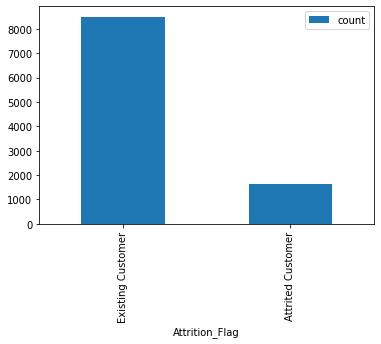

In [14]:
df.groupby("Attrition_Flag").count().toPandas().set_index(["Attrition_Flag"]).plot(
    kind="bar"
)
plt.show()

Vemos que la clase objetivo (Attrited Customer) está desbalanceada, tendremos que tenerlo en cuenta en el modelo para poder predecirla correctamente.

## Procesado de las variables

Antes de poder aplicar los modelos de aprendizaje automático tenemos que hacer algunas transformaciones en las variables.
- Primero vamos a codificar con números las variables categóricas.
- A las variables categóricas creadas les vamos a aplicar una codificación One Hot.
- Después crearemos un vector con todas las variables que vamos a utilizar para el entrenamiento.

Pasaremos todas las transformaciones por una pipeline.

In [15]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LogisticRegression
from pyspark.ml import Pipeline
from pyspark.ml.feature import (
    StringIndexer,
    VectorAssembler,
    OneHotEncoder,
)

In [16]:
categories = [t[0] for t in df.dtypes if t[1] == "string"]
numeric_features = [t[0] for t in df.dtypes if t[1] == "int" or t[1] == "double"]

indexer = StringIndexer(
    inputCols=categories,
    outputCols=[col + "_index" for col in categories],
)

encoder = OneHotEncoder(
    inputCols=[col + "_index" for col in categories],
    outputCols=[col + "_encoded" for col in categories],
)

assembler = VectorAssembler(
    # No queremos la variable respuesta en el vector de variables usadas para predecir
    inputCols=[col + "_encoded" for col in categories if col != "Attrition_Flag"]
    + numeric_features,
    outputCol="features",
)
pipeline = Pipeline(stages=[indexer, encoder, assembler])
df = pipeline.fit(df).transform(df)

In [17]:
df.groupby("Attrition_Flag").avg("Attrition_Flag_index").show(5)

+-----------------+-------------------------+
|   Attrition_Flag|avg(Attrition_Flag_index)|
+-----------------+-------------------------+
|Existing Customer|                      0.0|
|Attrited Customer|                      1.0|
+-----------------+-------------------------+



Vemos que se ha codificado como 0 la clase mayoritaria 'Existing Customer', mientras que la clase objetivo 'Attrited Customer' se ha codificado como 1.

## Preparación del conjunto de entrenamiento y de test, columna de pesos 

Vamos a dividir los datos en dos conjuntos, uno para el entrenamiento y otro para evaluar los modelos.
El conjunto de entrenamiento tendrá un 80% de los datos y el de test un 20%.

Además, sabemos que la clase que queremos predecir está desbalanceada, así que vamos a calcular una columna con los pesos de cada clase que usaremos luego en el entrenamiento. A cada clase le asignaremos un peso igual a: 

$$\frac{número\ total\ de\ muestras}{(número\ de\ clases * número\ de\ muestras\ por\ clase)}$$

In [18]:
# Creación del train y test set
train_set, test_set = df.select("Attrition_Flag_Index", "features").randomSplit(
    [0.8, 0.2]
)

In [19]:
# Creando la columna weight para tener en cuente que la clase que queremos predecir está desbalanceada
temp = train_set.groupby("Attrition_Flag_Index").count()
temp = train_set.join(temp, "Attrition_Flag_Index", how="leftouter")
balanced_train_set = temp.withColumn("weight", (temp.count() / (2 * temp["count"])))
balanced_train_set.groupby("weight").count().show()

+------------------+-----+
|            weight|count|
+------------------+-----+
|3.1142638036809815| 1304|
|0.5956292167791141| 6818|
+------------------+-----+



## Entrenamiento y test
Se van a evaluar dos modelos diferentes:
- Logistic Regression
- Random Forest Classifier

El único hiperparámetro que voy a utilizar es la columna de pesos, por lo demás se usarán los modelos con sus valores por defecto.

Además he preparado una función para evaluar las prediciones. He intentando encontrar alguna función similar en los paquetes de Spark, pero no he econtrado nada cómodo de usar. Así que en los modelos desarrollados en este ejercicio he usado la siguiente función para evaluarlos: 

In [20]:
def evaluate_pred(predictions):
    P = predictions.filter(predictions["Attrition_Flag_Index"] == 1).count()
    N = predictions.filter(predictions["Attrition_Flag_Index"] == 0).count()
    TP = predictions.filter(
        (predictions["prediction"] == 1) & (predictions["Attrition_Flag_Index"] == 1)
    ).count()
    TN = predictions.filter(
        (predictions["prediction"] == 0) & (predictions["Attrition_Flag_Index"] == 0)
    ).count()
    FP = predictions.filter(
        (predictions["prediction"] == 1) & (predictions["Attrition_Flag_Index"] == 0)
    ).count()
    FN = predictions.filter(
        (predictions["prediction"] == 0) & (predictions["Attrition_Flag_Index"] == 1)
    ).count()
    recall = TP / P
    precision = TP / (TP + FP)
    accuracy = (TP + TN) / (P + N)
    print(f"Recall: {recall}\nPrecision: {precision}\nAccuracy: {accuracy}")

### Logistic Regression

Vamos a evaluar el modelo de regresión logistica con y sin la columna de pesos.

In [21]:
# LogisticRegression sin pesos

lr = LogisticRegression(
    labelCol="Attrition_Flag_Index",
    featuresCol="features",
    #    weightCol="weight",
)
model = lr.fit(balanced_train_set)
predictions = model.transform(test_set)
evaluate_pred(predictions)

Recall: 0.5944272445820433
Precision: 0.768
Accuracy: 0.9057356608478803


In [22]:
# LogisticRegression con pesos

lr = LogisticRegression(
    labelCol="Attrition_Flag_Index",
    featuresCol="features",
    weightCol="weight",
)
model = lr.fit(balanced_train_set)
predictions = model.transform(test_set)
evaluate_pred(predictions)

Recall: 0.8390092879256966
Precision: 0.5037174721189591
Accuracy: 0.8408977556109726


### Random Forest Classfier

Vamos a evaluar el modelo de random forest con y sin la columna de pesos.

In [23]:
# RandomForestClassifier sin pesos
rf = RandomForestClassifier(
    labelCol="Attrition_Flag_Index",
    featuresCol="features",
    # weightCol="weight",
)
model = rf.fit(balanced_train_set)
predictions = model.transform(test_set)
evaluate_pred(predictions)

Recall: 0.5263157894736842
Precision: 0.845771144278607
Accuracy: 0.9082294264339152


In [24]:
# RandomForestClassifier con pesos
rf = RandomForestClassifier(
    labelCol="Attrition_Flag_Index",
    featuresCol="features",
    weightCol="weight",
)
model = rf.fit(balanced_train_set)
predictions = model.transform(test_set)
evaluate_pred(predictions)

Recall: 0.8947368421052632
Precision: 0.6393805309734514
Accuracy: 0.9017456359102244


## Conclusiones

Observando los resultados podemos obtener algunas conclusiones interesantes:
- Hemos conseguido aumentar el recall en los dos modelos estudiados al incluir en ellos la columna de pesos. Se produce un aumento de aproximadamente 0.60 a 0.90. Este aumento es muy importante ya que estamos consiguiendo encontrar casi un 90% de los clientes que pretender abandonar el servicio.
- La exactitud se mantiene en torno a 0.90 en todos los modelos.
- Sin embargo, la precisión vemos que baja, a unos valores en torno 0.50-0.60. Esto es un comportamiento típico ya que al mejorar el recall se tiende a aumentar el número de falsos positivos. En este problema en particular, el objetivo es aumentar el recall y no nos afecta demasiado la disminución en precisión ya que simplemente intentaremos convencer a clientes de no irse aunque no pensaran en marcharse. Aun así, se estarían malgastando recursos y sería mejor tener un valor alto en la precisión también. 
- En general, los dos modelos obtienen resultados muy parecidos al incluir los pesos, aunque el modelo de random forest parece que se comporta mejor.

Comparando con la tarea original en el dataset, que era de alcanzar un recall mayor de 62%, vemos que hemos alcanzado el objetivo. Por otro lado, todavía se podría mejorar los modelos para intentar aumentar aún más el recall y evitar perdidas en la precisión.